In [25]:
import fitsio
import numpy as np
import k3d
import pandas as pd
import SEdist
import pygwalker as pyg

import scipy.spatial

from astropy.coordinates import SkyCoord
from astropy.cosmology import Planck15 as default_cosmo
import astropy.units as u

def add_cartesian_coordinates(df, cosmo=default_cosmo, redshifts=None):
    # Extract RA, Dec, and redshift from the DataFrame
    ra = df['ra'].values
    dec = df['dec'].values
    if redshifts is None:
        redshifts = df['redshift_quaia'].values 
    else:
        df['redshifts'] = redshifts

    # Calculate comoving distance using the cosmology model
    comoving_distance = cosmo.comoving_distance(redshifts)

    # Create SkyCoord object
    coords = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, distance=comoving_distance)

    # Convert to Cartesian coordinates
    x = coords.cartesian.x.value
    y = coords.cartesian.y.value
    z = coords.cartesian.z.value

    # Add Cartesian coordinates to the DataFrame
    df['x'] = np.float32(x)
    df['y'] = np.float32(y)
    df['z'] = np.float32(z)

    return df


# Helper function to generate a mesh for a sphere geometry to display with k3d
def generate_sphere(radius=1.0, center=(0, 0, 0), resolution=30):
    u = np.linspace(0, 2 * np.pi, resolution)
    v = np.linspace(0, np.pi, resolution)
    u, v = np.meshgrid(u, v)

    x = center[0] + radius * np.cos(u) * np.sin(v)
    y = center[1] + radius * np.sin(u) * np.sin(v)
    z = center[2] + radius * np.cos(v)

    # Flatten arrays
    vertices = np.vstack([x.ravel(), y.ravel(), z.ravel()]).T

    # Create faces (triangular mesh)
    faces = []
    for i in range(resolution - 1):
        for j in range(resolution - 1):
            p1 = i * resolution + j
            p2 = p1 + 1
            p3 = (i + 1) * resolution + j
            p4 = p3 + 1
            faces.append([p1, p2, p3])
            faces.append([p2, p4, p3])

    faces = np.array(faces, dtype=np.uint32)

    return vertices, faces


In [2]:
# Read FITS data from the specified directory
d205 = fitsio.read('../../data/quaia/quaia_G20.5.fits')
r205 = fitsio.read('../../data/quaia/random_G20.5_10x.fits')

df = pd.DataFrame(d205.byteswap().newbyteorder())
rf = pd.DataFrame(r205.byteswap().newbyteorder())

# Add cartesian coordinates DataFrame
df = add_cartesian_coordinates(df)

# randoms do not have redshifts. Let's create them from the redshift distribution of the data. 
sez =  SEdist.SE_distribution(df["redshift_quaia"]) # create empirical empirical distribution function
newz = sez.rvs(size=len(rf['ra']))                  # samples new random variates from it
rf = add_cartesian_coordinates(rf, redshifts=newz)

In [3]:

# Convert the FITS data to a pandas DataFrame with native byte order
#pyg.walk(df)

In [4]:
# Convert the FITS data to a pandas DataFrame with native byte order
pyg.walk(rf)

Box(children=(HTML(value='\n<div id="ifr-pyg-00062e87475dc8a4GZcTm5nfOdr7iL6S" style="height: auto">\n    <hea…

In [ ]:
import k3d
from scipy.spatial import distance

# Create a plot
plot = k3d.plot()

# Calculate the distance of each point from the origin
distances = np.sqrt(df['x']**2 + df['y']**2 + df['z']**2)

# Find the radius that encompasses 99% of the points
radius_99 = np.percentile(distances, 99)

# Generate sphere vertices and faces
vertices, faces = generate_sphere(radius=radius_99, center=(0, 0, 0), resolution=30)

# Create a mesh for the sphere
sphere_mesh = k3d.mesh(vertices, faces, color=0xff0000, opacity=0.3, wireframe=True)
# Add the sphere to the plot
plot += sphere_mesh

# Label the sphere with its redshift value
label = k3d.text(
    text=f'Redshift: {np.percentile(df["redshift_quaia"], 99):.2f}',
    position=[radius_99, 0, 0],
    color=0xff0000,
    size=1.0
)

# Add the label to the plot
plot += label

# Create a 3D scatter plot
colors = np.float32(df['redshift_quaia'].values)
#points = k3d.points(positions=np.vstack([df['x'],df['y'],df['z']]).T, point_size=0.1, color_map=k3d.colormaps.matplotlib_color_maps.Jet, attribute=colors)

# Add points to the plot
#plot += points

# Display the plot
#plot.display()

/Users/tabel/pyEnvs/k3dEnv/lib/python3.11/site-packages/traittypes/traittypes.py:97: UserWarning: Given trait value dtype "float64" does not match required type "float32". A coerced copy has been created.
  warnings.warn(


In [6]:
dt = scipy.spatial.cKDTree(np.vstack([df['x'],df['y'],df['z']]).T) # tree of data
rt = scipy.spatial.cKDTree(np.vstack([rf['x'],rf['y'],rf['z']]).T) # tree of randoms

### Find the distances to the k-th nearest neighbors
We measure from the randoms to the k-th data point and record the distances

In [74]:
#ks = [1, 2, 4, 8, 9, 16, 25, 128]
#ks = [1, 2, 8, 9, 64, 65, 512, 513, 4096, 4097] # which neighbours 
ks = [1, 2, 8, 9, 64, 65, 512, 513] # which neighbours 
dis, disi =  dt.query(np.vstack([rf['x'],rf['y'],rf['z']]).T, k=ks, workers=-1) # query data tree at randoms

### Given the distances now measure the volume
By measuring how many randoms are in the spheres of the size to the k-th nearest data point we get a volume estimate exploiting the randoms property of being uniformly distributed. 

In [89]:
indices = np.random.choice(len(rf['x']), 3_000_000, replace=False)  # downsample [is faster]
#indices = np.arange(len(rf['x']))
for c, k in enumerate(ks):
    rl = rt.query_ball_point( (np.vstack([rf['x'],rf['y'],rf['z']]).T)[indices,:], dis[indices,c], return_length=True, workers=-1)
    cdfs[k] = SEdist.SE_distribution(rl, compress="log", Ninterpolants=50000)
#cdfs[k] = SEdist.SE_distribution(rl)
    

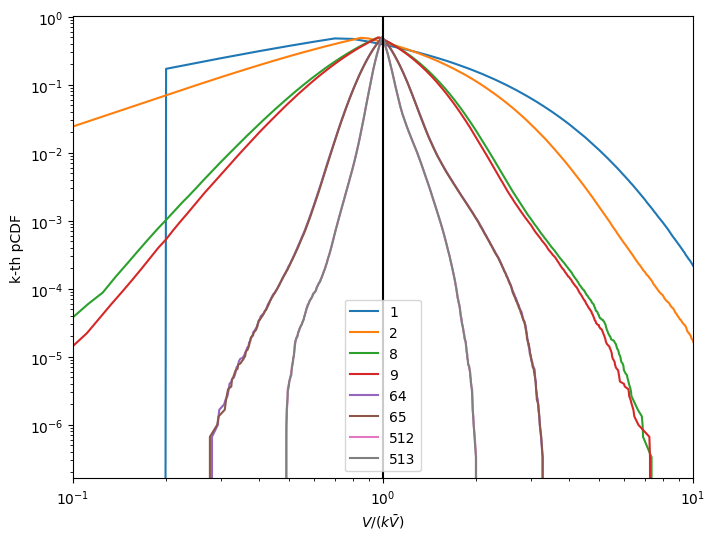

In [90]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))

for c, k in enumerate(ks):
    plt.loglog(cdfs[k].x()/k/10, cdfs[k].pcdf(cdfs[k].x()),label=str(k))
plt.axvline(1,color='black')
plt.xlabel(r'$V/(k\bar{V})$')
plt.ylabel(r'k-th pCDF')
plt.xlim([1e-1,1e1])
plt.legend();

Equation 8 of [Banerjee & Abel 2022](https://doi.org/10.1093/mnras/staa3604) :
$$
P_{k \mid V}=\mathrm{CDF}_{k \mathrm{NN}}(r)-\mathrm{CDF}_{(k+1) \mathrm{NN}}(r) \quad \forall k \geq 1
$$


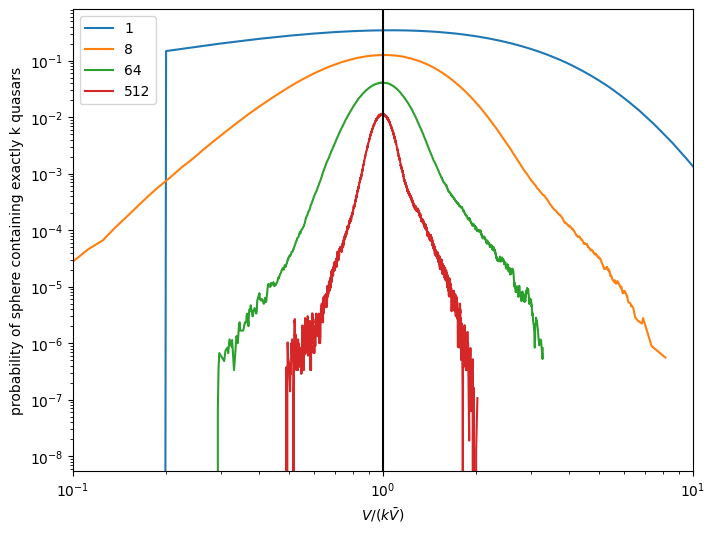

In [91]:
# P_k
fig = plt.figure(figsize=(8,6))
for c, k in enumerate(ks[::2]):
    plt.loglog(cdfs[k].x()/k/10, cdfs[k].cdf(cdfs[k].x())-cdfs[k+1].cdf(cdfs[k].x()),label=str(k))
plt.axvline(1,color='black')
plt.xlabel(r'$V/(k\bar{V})$')
plt.ylabel(r'probability of sphere containing exactly k quasars')
plt.xlim([1e-1,1e1])
plt.legend();